In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Importing requried method from stats model Libraries

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, rmspe

<font color = blue> <b> For this analysis we'll also compare money to spending. We'll look at the M2 Money Stock which is a measure of U.S. personal assets, and U.S. personal spending. Both datasets are in billions of dollars, monthly, seasonally adjusted. They span the 21 years from January 1995 to December 2015 (252 records).
Sources: https://fred.stlouisfed.org/series/M2SL https://fred.stlouisfed.org/series/PCE

In [6]:
# Loading the Dataset

# Data set containing Details of the Personal assets
Y1 = pd.read_csv("Data/M2SLMoneyStock.csv", index_col=0, parse_dates=True)
Y1.index.freq ='MS'
# Data set containing details of Personal Spendings

Y2 = pd.read_csv("Data/PCEPersonalSpending.csv", index_col=0, parse_dates=True)
Y2.index.freq ='MS'

In [8]:
Y1.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [9]:
Y2.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [10]:
# JOining the Both  the Data Set

Y1 = Y1.join(Y2)

Y1.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [1]:
# Plotting the Data to See  the Trend

Y1.plot(figsize = (12,8))

NameError: name 'Y1' is not defined

### <font color = red> Checking Stationarity of the Data set

In [12]:
# Creating a Function for the Checking the Stationarity of the Data Set using the AD fuller method.

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [16]:
# Checking the Stationarity oof the First Column
adf_test(Y1['Money'], 'US Data for Income')

Augmented Dickey-Fuller Test: US Data for Income
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [17]:
# Checking the Stationarity of the Second Column

adf_test(Y1['Spending'], "US Data for Spending")

Augmented Dickey-Fuller Test: US Data for Spending
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


<font color = green> <b> From the above test of Staionarity we can confirm both datas : Income and Spending are Non-Stationarity

### <font color = red> Converitng The Data to Stationary Data by Differencing of First  Order

In [18]:
Y1_Transform = Y1.diff()

In [19]:
Y1_Transform.head() 

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,-2.5,-0.4
1995-03-01,1.2,34.6
1995-04-01,8.1,4.8
1995-05-01,25.0,42.9


<AxesSubplot:xlabel='Date'>

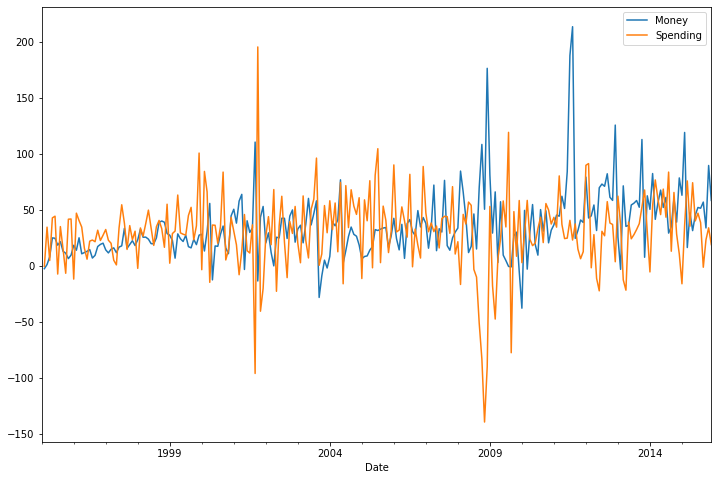

In [20]:
Y1_Transform.plot(figsize=(12,8))

In [22]:
# Rerunning the ADfuller test to Check the Stationarity

print(adf_test(Y1_Transform['Money'], 'US Data for Income'))
print(adf_test(Y1_Transform['Spending'], 'US Data for Income'))

Augmented Dickey-Fuller Test: US Data for Income
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
None
Augmented Dickey-Fuller Test: US Data for Income
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None


<font color =green> <b> Form the Above Plot and ADfuller test after performing the Differencing of first order:
- Money Column is still non Stationary
- Spending Column is Stationary.

<font color = blue> <b> Appling second oreder Differencing on both the Columns.
        
    we will perform differencing on boththe columns to get same numbers of rows for VAR Model.

In [23]:
Y1_Transform  = Y1_Transform.diff().dropna()
Y1_Transform.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [24]:
# Performing the ADfuller test to Check the Stationarity

print(adf_test(Y1_Transform['Money'], 'US Data for Income'))
print(adf_test(Y1_Transform['Spending'], 'US Data for Income'))

Augmented Dickey-Fuller Test: US Data for Income
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None
Augmented Dickey-Fuller Test: US Data for Income
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None


<AxesSubplot:xlabel='Date'>

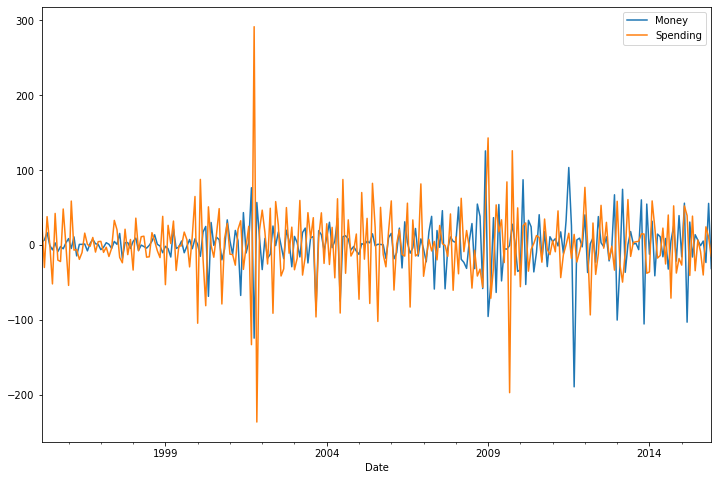

In [25]:
Y1_Transform.plot(figsize=(12,8))

### <font color = red> Train-Test Split

In [26]:
# Number of Observation in Test Set

nobs = 12

In [27]:
train = Y1_Transform[:-nobs]
test = Y1_Transform[-nobs:]

### <font color=red> Performing The Grid Search for finding Order p of AR in VAR model

In [33]:
model = VAR(train)

# Fitting the model different values of p and Compairing their AIC values

for p in range(1,8):
    results = model.fit(p)
    print(f"For Order{p} the AIC value is {np.round(results.aic,2)}")

For Order1 the AIC value is 14.18
For Order2 the AIC value is 13.96
For Order3 the AIC value is 13.85
For Order4 the AIC value is 13.83
For Order5 the AIC value is 13.79
For Order6 the AIC value is 13.8
For Order7 the AIC value is 13.8


<font color=green> <b> From the above grid search we can see that the AIC value is Lowest for p=5 and Is againg started increasing after that.
So we will go for VAR model of order 5

In [35]:
results = model.fit(5)

In [36]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 20, Jan, 2021
Time:                     21:21:04
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

In [40]:
# Grab the 5 Lagged Value Right Before the test Set Start

lagged_value = train.values[-5:]
lagged_value.shape  

# VAR forcast method will take the np array of dimensions (p X k), where p is no of lagged or order of AR
# k is no of variables
# Here p is 5 and k is 2

(5, 2)

In [44]:
# Forcating for the test data
# The forcasted value have differencing  of 2nd order

fcast_test = results.forecast(y=lagged_value,steps=12)

In [45]:
# Creating a Date Index

idx = pd.date_range("2015-01-01", periods=12, freq='MS')
idx

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [66]:
# Creating The Data Frame of Forcasted Value for Test Data

df_fcast_test = pd.DataFrame(fcast_test, index=idx,columns=["Money_2d", "Spending_2d"])

In [67]:
df_fcast_test.head()

,Money_2d,Spending_2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365


### <font color = red> Invert the Transformation

<font color = blue> <b> The forecasted values represent second-order differences. To compare them to the original data we have to roll back each difference. To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values. When working with second-order differences we first must perform this operation on the most recent first-order difference.

Here we'll use the nobs variable we defined during the train/test/split step.

In [68]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_fcast_test['Money_1d'] = (Y1['Money'].iloc[-nobs-1] - Y1['Money'].iloc[-nobs-2]) + df_fcast_test['Money_2d'].cumsum()

# Now build the forecast values from the first difference set
df_fcast_test['MoneyForecast'] = Y1['Money'].iloc[-nobs-1] + df_fcast_test['Money_1d'].cumsum()

In [69]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_fcast_test['Spending_1d'] = (Y1['Spending'].iloc[-nobs-1] - Y1['Spending'].iloc[-nobs-2]) + df_fcast_test['Spending_2d'].cumsum()

# Now build the forecast values from the first difference set
df_fcast_test['SpendingForecast'] = Y1['Spending'].iloc[-nobs-1] + df_fcast_test['Spending_1d'].cumsum()

In [70]:
df_fcast_test.head()

,Money_2d,Spending_2d,Money_1d,MoneyForecast,Spending_1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


### <font color = red> Plotting the Actual and Forcasted Data

<AxesSubplot:xlabel='Date'>

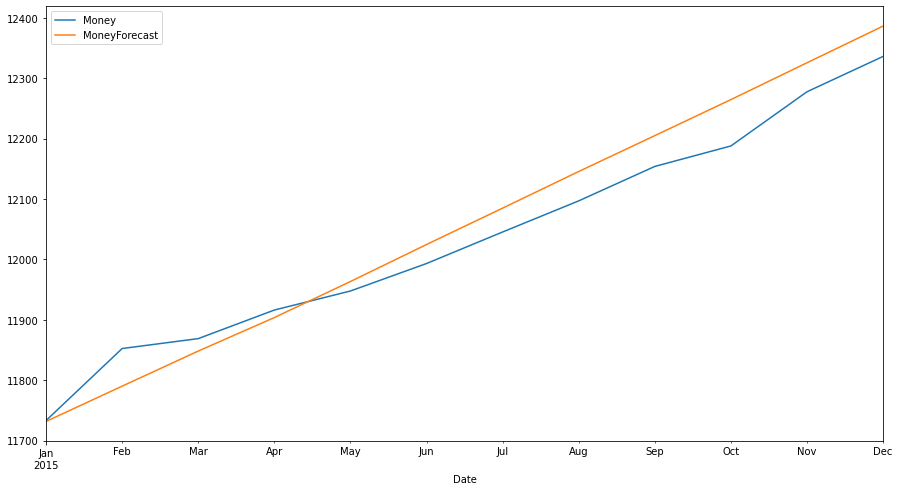

In [72]:
# Plotting for Money Column
Y1.iloc[-nobs:]["Money"].plot(figsize=(15,8), legend=True)
df_fcast_test["MoneyForecast"].plot(legend=True)

<AxesSubplot:xlabel='Date'>

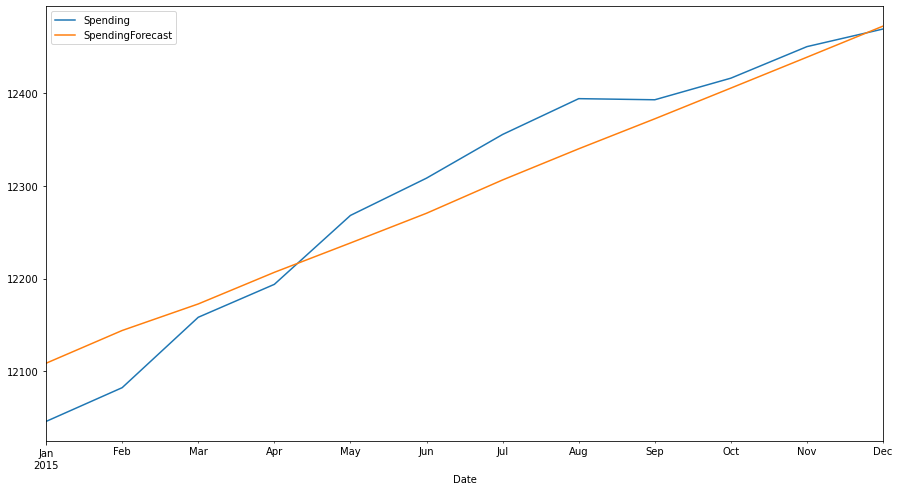

In [73]:
# Plotting for SPending Column
Y1.iloc[-nobs:]["Spending"].plot(figsize=(15,8), legend=True)
df_fcast_test["SpendingForecast"].plot(legend=True)

### <font color = red> Evaluating Quatitatively

In [76]:
print("RMSE for Income column is: ", np.round(rmse(Y1.iloc[-nobs:]["Money"],df_fcast_test["MoneyForecast"]),2))
print("Mean of Income For Test Range is:", np.round(Y1.iloc[-nobs:]["Money"].mean(),2))
print("RMSE for Spending column is: ", np.round(rmse(Y1.iloc[-nobs:]["Spending"],df_fcast_test["SpendingForecast"]),2))
print("Mean of Spending For Test Range is:", np.round(Y1.iloc[-nobs:]["Spending"].mean(),2))

RMSE for Income column is:  43.71
Mean of Income For Test Range is: 12034.01
RMSE for Spending column is:  37.0
Mean of Spending For Test Range is: 12294.53
